# Vehicle Sliding Windows Search
In this notebook we tackle the second task in the Vehicle Detection Pipeline: we search for bounding boxes that contain a car. This can be broken into two steps

* define a fixed set of windows
* using heat-map to filter out false positive and multiple-detection

First let's import some modules

In [1]:
import glob
import os
import time
import numpy as np
import pandas as pd
import cv2
import pickle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

 And load trained classifier

In [23]:
# first load trained model
trained_file = 'trained_model_luv.pkl'
with open(trained_file, 'rb') as f:
    trained_model = pickle.load(f)

clf = trained_model['clf']
feat_settings = trained_model['feat_settings']

## Multi-scale search windows
Let's visualize our test images:

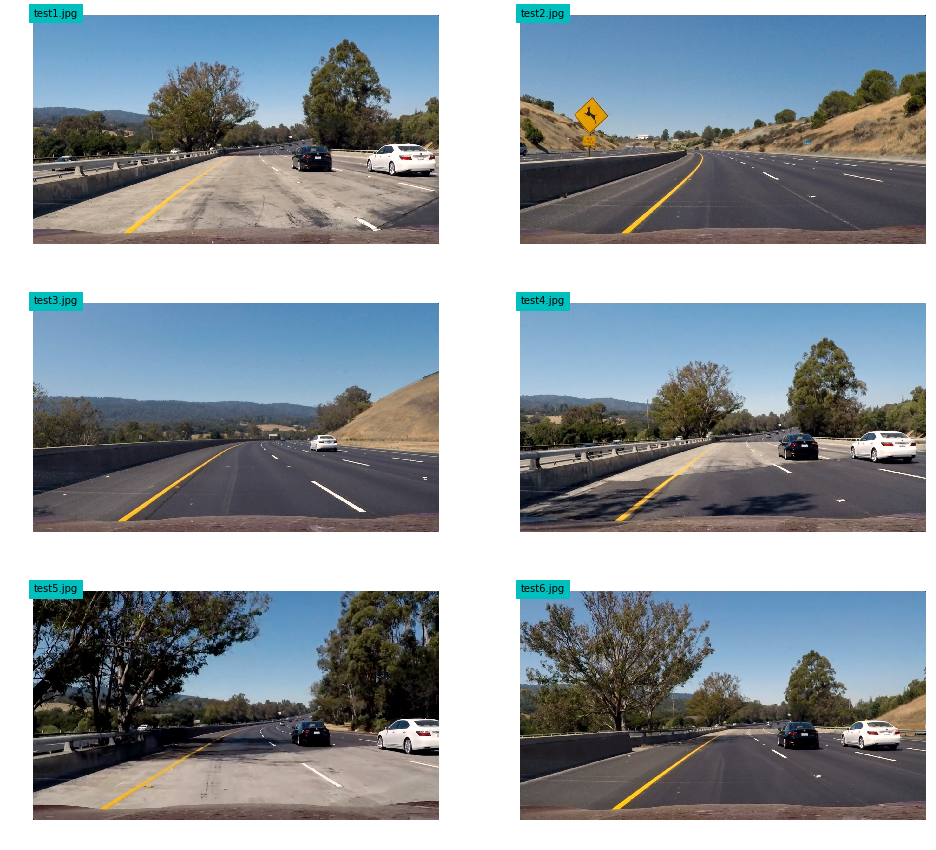

In [3]:
from utils import list_imgs, show_img, grid_view, view_imgs

test_files = list_imgs(['./test_images'], 'jpg')
imgs = [mpimg.imread(test_file) for test_file in test_files]
labels = [os.path.basename(test_file) for test_file in test_files]

grid_view(imgs, labels, (16,15), ncols=2, nrows=(1+len(imgs))//2)

We notice that in our images, vehicle can be small or big depends on their location in the images, so it would be better to use multi-scale windows as suggested in the project page. The function that creates search windows is implemented in `lesson_utils.slide_window`, here we implemented multi-scale search windows

Number of search windows 321


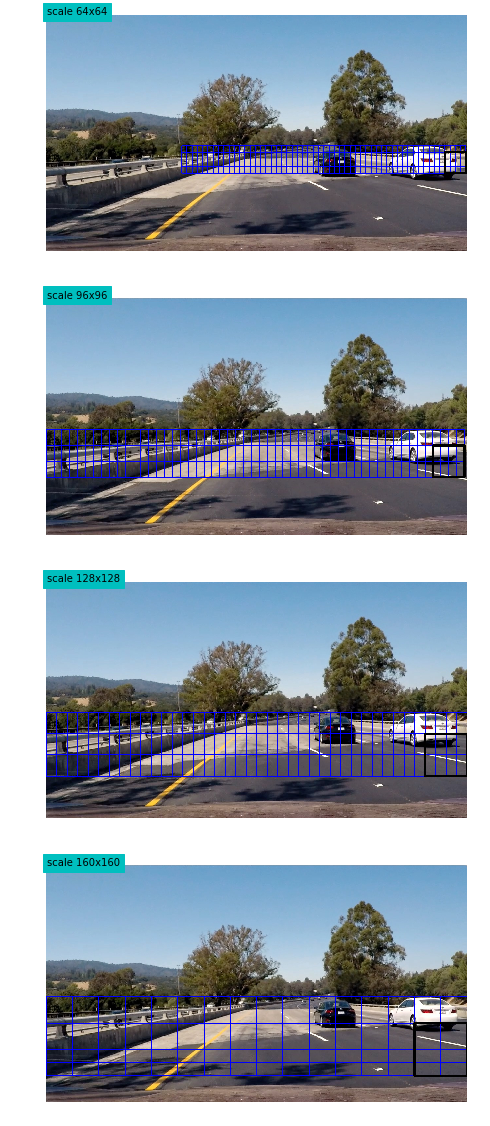

In [47]:
from lesson_utils import slide_window, draw_boxes

def multi_scale_windows(img_shape, 
                        scales = [64, 96, 128],
                        x_start_stops = [[None, None],  [None, None], [None, None]],
                        y_start_stops = [[400, 500]  , [400,  550],  [400,  600]],
                        x_overlaps   =  [0.5, 0.5, 0.5],
                        y_overlaps   =  [0.5, 0.5, 0.5]):
    windows = []
    colors  = []
    for i, scale in enumerate(scales):
        boxes = slide_window(img_shape,
                             x_start_stops[i],
                             y_start_stops[i],
                             xy_window=(scale, scale),
                             xy_overlap=(x_overlaps[i], y_overlaps[i]))
        colors  += [i]*len(boxes)
        windows += boxes
    return windows, colors

def visualize_search_windows(img, scales, windows, colors, figsize=(8,20)):
    imgs   = []
    labels = []
    windows = np.array(windows)
    colors = np.array(colors)
    for i,scale in enumerate(scales):
        idx = np.where(colors == i)[0]        
        imgs.append(draw_boxes(img, windows[idx], color=(0,0,255), color_lastbox=True))
        labels.append('scale {}x{}'.format(scale, scale))
    view_imgs(imgs, labels, figsize, False)

# Settings for multi-scale windows
scales        = [64, 96, 128, 160]
x_start_stops = [[412, None],   [None,   None], [None, None], [None, None]]
y_start_stops = [[400, 500]  ,  [400,  550],  [400,  600],  [400, 640]]
x_overlaps    = [0.75, 0.75, 0.75, 0.5]
y_overlaps    = [0.70, 0.5,  0.5,  0.75]

# Computing windows and colors
windows, colors = multi_scale_windows(imgs[0].shape, scales, x_start_stops, y_start_stops, x_overlaps, y_overlaps)
visualize_search_windows(imgs[3], scales, windows, colors)
print('Number of search windows {}'.format(len(windows)))

Now let's try to search for bound-boxes that contains vehicle, it's implemented in `lesson_utils.search_windows`

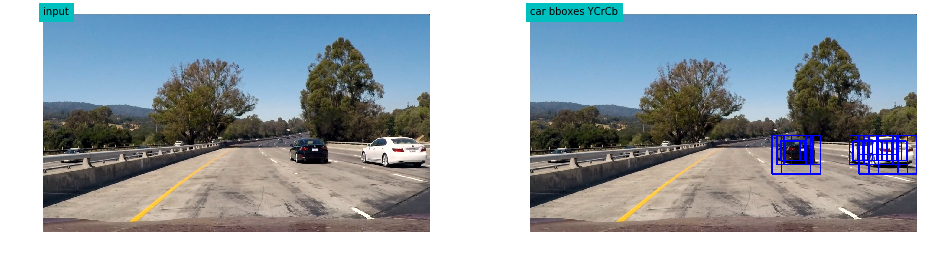

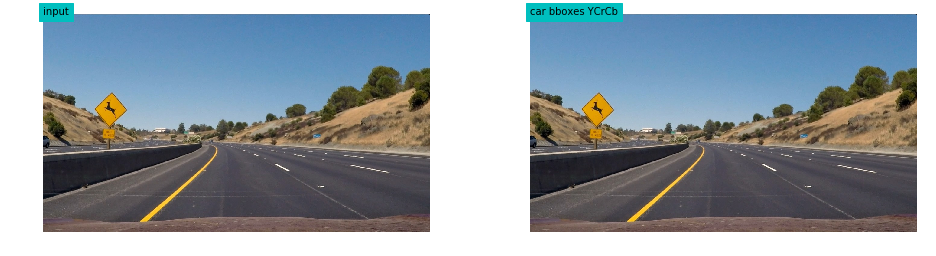

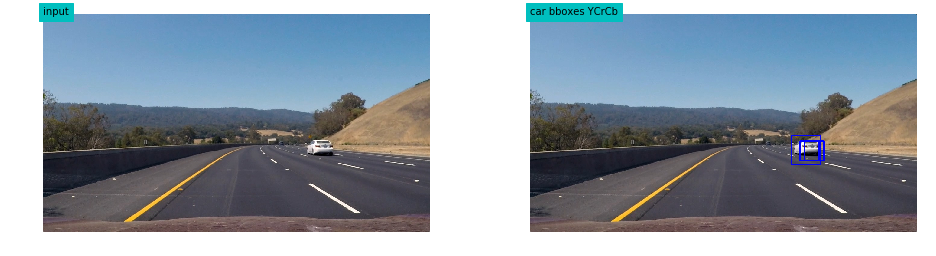

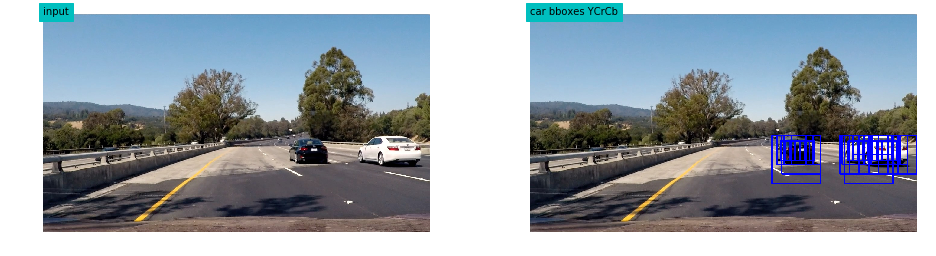

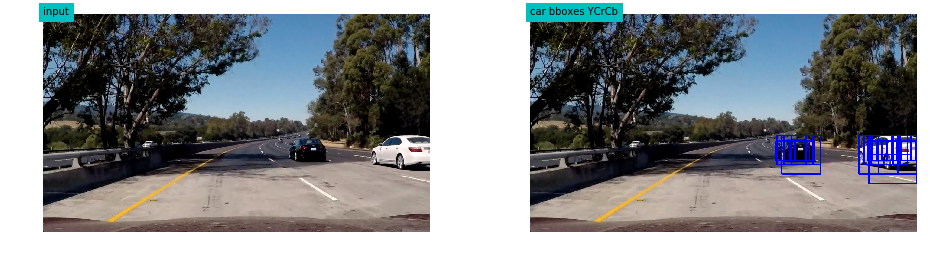

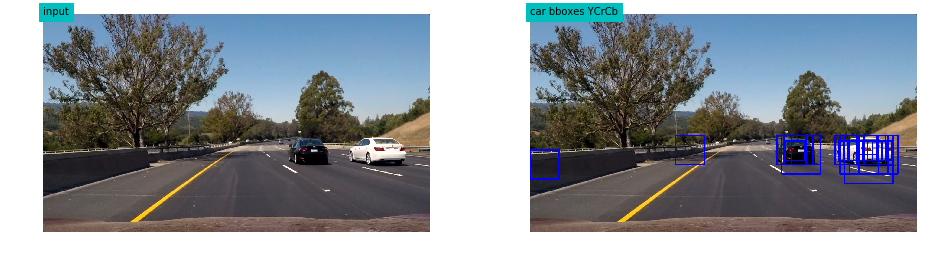

In [48]:
from lesson_utils import search_windows
def visualize_carbb(img, windows, clf, **feat_settings):
    car_bboxes = search_windows(img, windows, clf, **feat_settings)
    img_carbb = draw_boxes(img, car_bboxes, thick=3)
    view_imgs([img, img_carbb], ['input', 'car bboxes {}'.format(feat_settings['color_space'])], figsize=(16,4))

for img in imgs:    
    visualize_carbb(img, windows, clf, **feat_settings)    

From above image, we can see false-positive and multiple detection. As suggested in the project-page, one could emply heat-map technique to filter out false-positive and multiple-detection.

Let's test other trained classifier (i.e in other color-space)

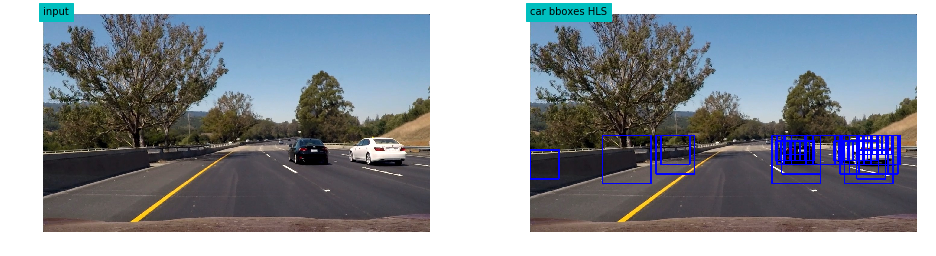

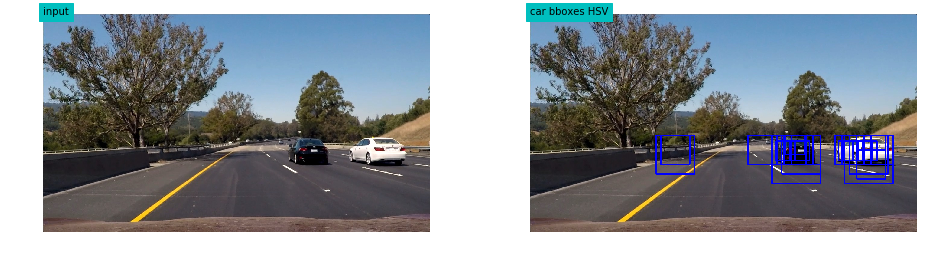

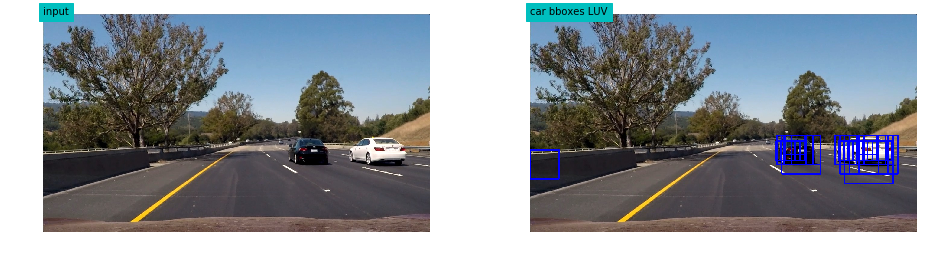

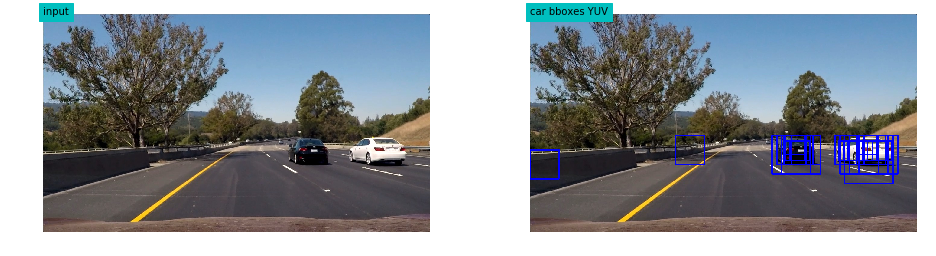

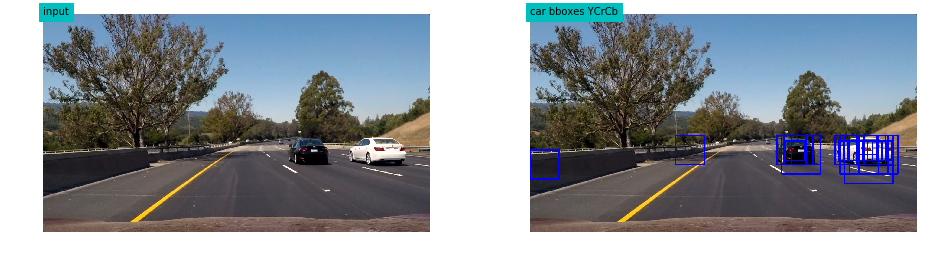

In [49]:
for cspace in ['hls', 'hsv', 'luv', 'yuv', 'ycrcb']:
    trained_file = 'trained_model_{}.pkl'.format(cspace)
    with open(trained_file, 'rb') as f:
        trained_model = pickle.load(f)
    clf = trained_model['clf']
    feat_settings = trained_model['feat_settings']   

    visualize_carbb(imgs[5], windows, clf, **feat_settings)

## Heat-map 
The heat-map technique is well explained in the project page so we don't repeat it here, it's implemented in `lesson_utils.heat_map_bbox`. Now let's try it on our test images

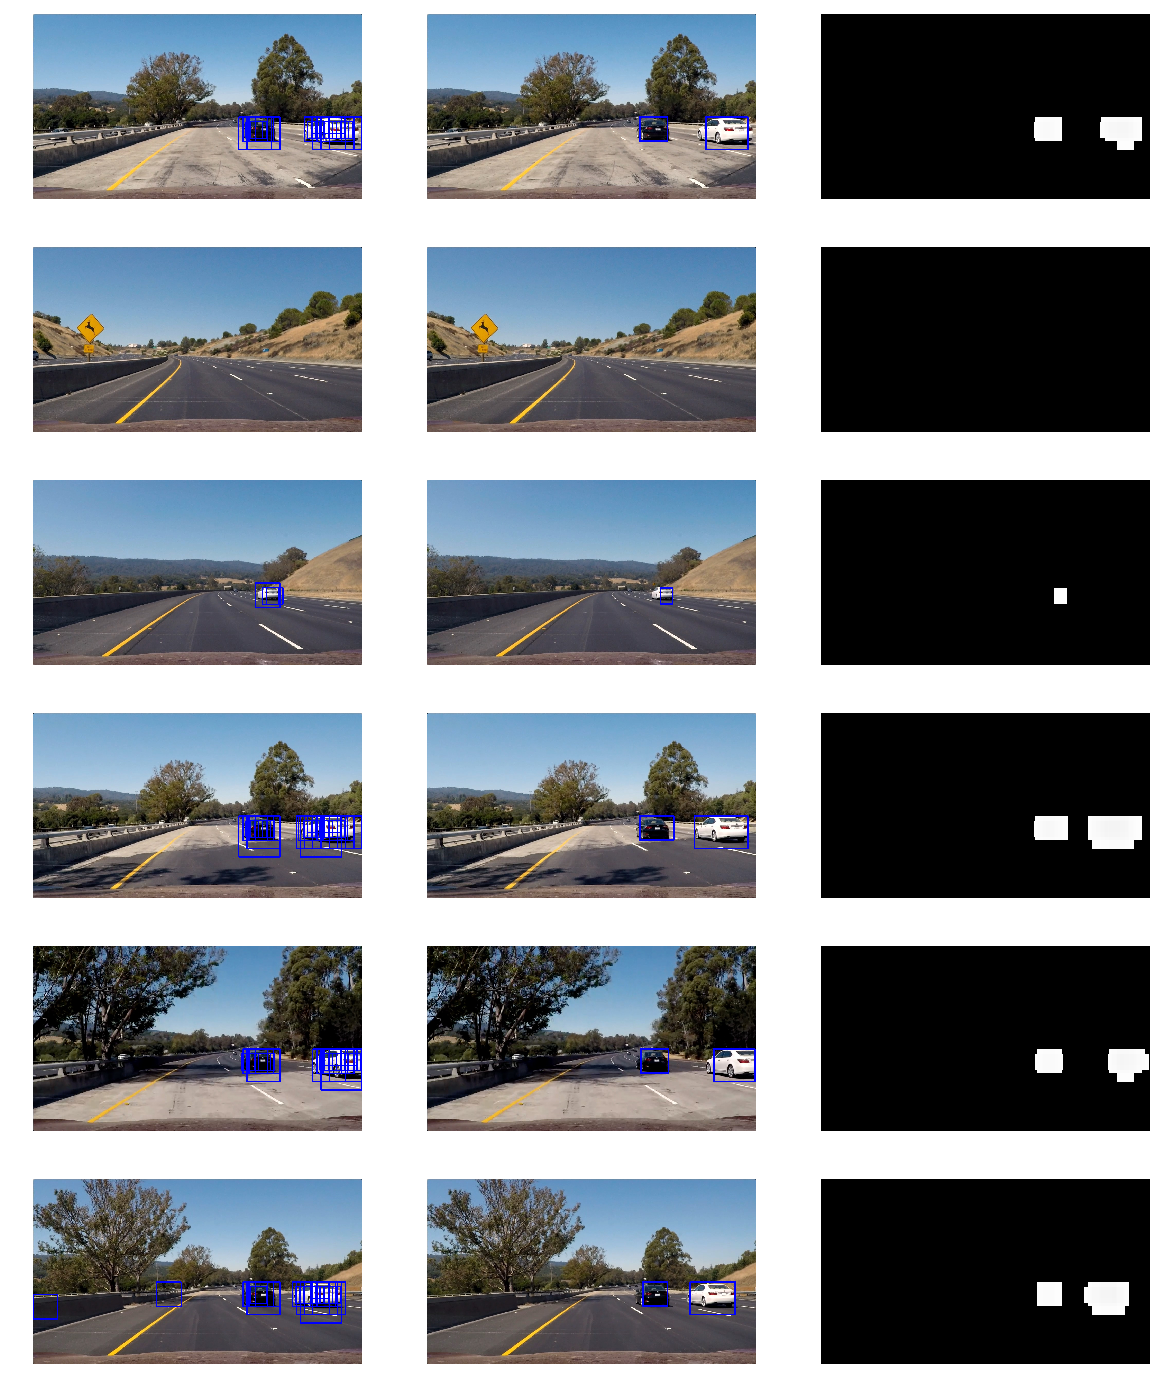

In [50]:
from lesson_utils import heat_map_bbox
def visualize_heatmap_bbox(imgs, windows, clf, threshold=2,figsize=(20,25), **feat_settings):
    out_imgs = []
    cmaps = []
    for img in imgs:
        car_bboxes = search_windows(img, windows, clf, **feat_settings)
        hm_bboxes, hm = heat_map_bbox(img, car_bboxes, threshold=threshold, debug=True)
        img_hmbb = draw_boxes(img, hm_bboxes, thick=6)
        out_imgs += [draw_boxes(img, car_bboxes, thick=3), img_hmbb, hm]
        cmaps += [None, None, 'gray']
    grid_view(out_imgs, [None]*len(out_imgs), figsize, nrows=len(imgs), ncols=3, cmaps=cmaps)

visualize_heatmap_bbox(imgs, windows, clf, **feat_settings)

Let's dumps the search windows so we can use in the next step

In [51]:
fileout = 'search_windows.pkl'
sw = {'img_shape' : imgs[0].shape,
      'windows' : windows}
with open(fileout, 'wb') as f:
    pickle.dump(sw, f)

## Selected parameters
After numerous of trial, we chose the following final setting

| Name           | Value                   | Note  |
| -------------: |:-----------------------:| :-----|
| trained model  | `trained_model_yuv.pkl` | We try other color space but it produces too much false positive/negative| 
| search windows | `search_windows.pkl`    | We go through a lot of trial/error and these seems working well|